# Module 1 - Connecting with and Controlling KITT

In this module we will start working with the car simulator and the car.
We will start with providing an overview and a brief description on getting to know the vehicle and implementing some basic control scripts. 

## Brief Overview

KITT is a remotely controlled vehicle. To allow for this remote control, a wireless link must be used.
Over this wireless link, control commands can be sent from the base station (your computer) to KITT.
This wireless link also facilitates requests for data from KITT and KITT’s data in response to these
requests. This project requires you to maneuver KITT in all sorts of ways. To get there, in this module, you will set up a
connection to KITT and work with basic controls to allow for more advanced actions later on.


### KITT Basics

KITT is based on a repurposed toy car model, the Traxass E-MAXX. As seen in this {ref}`KITT car <car-figure>` figure. There is a data sheet as well which gives an overview of the various components, such as the motor controller, LCD status indicator, ultrasonic sensors, and, most importantly, the communication module.


```{figure} traxxas_e-maxx.png
---
height/width: 150px
name: car-figure
---
Traxass E-MAXX along with it's dimensions
```

#### Hardware

Many components are combined on a single custom-made MCU board installed on KITT. The microcontroller forms the core of this board, an NXP LPC4357 chip with an ARM CORTEX-M4/M0 core. The MCU board contains the Bluetooth module, connectors for all peripherals, and an amplifier for the audio beacon, which will be used for the localization. The following figure {ref}`Schematic Overview of KITT communication with the PC <Schematic-overview>` shows a schematic overview of the connection.

The MCU is fed from the rechargeable batteries using a buck converter that converts the voltage to *5V* DC. Using an LM1117-3.3, *3.3V* is generated.


```{figure} communication_overview.png
---
height/width: 150px
name: Schematic-overview
---
Schematic of communication with KITT and PC.
```

The Bluetooth communication with KITT consists of the following elements:

-  On car: Roving Networks RN-41 I/RM, Onboard Bluetooth module with UART control.
-  On PC: LM Technologies LM506, USB Bluetooth V4.0 dongle with Broadcom BCM20702 chipset, or the internal Bluetooth module of your laptop.

You can use your computer's internal Bluetooth connector to connect to KITT. If you want to use one of the lab computers or have trouble connecting to KITT from your PC (check if all drivers are installed), you can use the USB Bluetooth dongle. 

KITT has four LED's, see figure {ref}`KITT <KITT>`, their meaning is as follows:

```{figure} figurejoin.png
---
height/width: 80px
name: KITT
---
(KITT)
```

- Red (twice): *5V* and *20V* supply voltages are present.
- Green (blinking): Bluetooth searches for connection; (steady) Bluetooth connected.
- Yellow (blinking): Bluetooth data transfer.

The button next to the LEDs is a reset button for the MCU. This reset button allows the user to reset KITT's actions if it freezes or is unresponsive.



### Communicating with KITT

In this section, we cover the essential concepts required to effectively communicate with the KITT system. In the following section, we will apply these principles in practice, implementing them in the simulator and the car.

#### pySerial 

pySerial is a Python module that provides a simple and efficient way to communicate with serial ports. It allows Python programs to access and manipulate the serial ports on a computer, allowing them to communicate with other devices connected to those ports. With pySerial, you can easily send and receive data to/from these devices. pySerial is cross-platform, which works on Windows, macOS, and Linux operating systems.

- *serial.Serial(port, baud rate)* - This command initializes a serial connection. The port argument specifies the serial port to use (e.g., "COM1" on Windows or "/dev/rfcomm0" on Linux),
and the baud-rate argument specifies the data rate in bits per second.
- *serial.write(data)* - This command sends data over the serial connection. The data argument is a bytes object that contains the data to be sent.
- *serial.read(size)* - This command reads a specified number of bytes from the serial connection. It blocks until the specified number of bytes is received.
- *serial.flush()* - This command is used to flush the input and output buffers of the serial connection.
- *serial.close()* - This command is used to close the serial connection.

Further more, updated information regarding the module can also be found through this link [pySerial](https://pyserial.readthedocs.io/en/latest/pyserial.html).

#### Connecting to KITT

To start off with, connect the car to your computer over Bluetooth. Make sure you know the name of the Bluetooth port that the car is connected to. To access the link in Python use,
```{code-cell}
serial_port = serial.Serial(comport, 115200, rtscts=True)
```
serial_port is an instance of pySerial and this object can be used to manipulate KITT. The variable comport is the path to the comport assigned to the Bluetooth connection with KITT. Which
comport specifically KITT is connected to can be found in your communication settings.

E.g., if your transmission connection to KITT takes place over port 10, then you should use:
comport = 'COM10'

Connecting to a serial port over Bluetooth can be pretty tricky. Windows users, refer to Appendix B. Linux users can use ‘# rfcomm bind rfcomm0 MAC_ADDRESS’; there is also a section about it on the Arch [Linux wiki](  https://wiki.archlinux.org/title/Bluetooth#Bluetooth_serial). The MAC address of KITT always ends with the code printed on its label. For example, if the label reads DA:84, the MAC will end with xx:xx:xx:xx:DA:84. 

To find out which serial ports are available, you can use the list_ports tool of pySerial. Run the following in a shell:

```{code-cell}
python -m serial.tools.list_ports
```

Further information regarding the issues with connecting to the port via Bluetooth can be solved by referring to the Appendices.

```{important} Click to Show
Also keep in mind, The Bluetooth connection is disturbed by leaving comports open, quitting your work without closing the communication link, removing the Bluetooth dongle, or turning off the Bluetooth connection. Avoid disturbing the Bluetooth connection by ending the connection properly before doing any of the aforementioned things. If you disturb the Bluetooth link, you may need to reboot your computer to reset the operating system, which costs you valuable lab time.

```
The connection must also be closed once you are done using the port, 

```{code-cell}
serial_port.close()
```

#### Controlling KITT

After connecting to KITT, commands are required to control it: Driving commands, Audio beacon commands, Status command.

__Driving Commands:__ First off, for driving there are 2 types of instructions:

-  A direction command.
-  A motor speed command.

These are controlled using Pulse width modulation.  Both commands are neutral at a setting of 150. The direction commands range from 200 (hard left) to 100 (hard right), and the motor commands range from 135 (backward) to 165 (forward).


```{note} Click to Show

However, there is a dead zone for the motor commands, so KITT will likely not start moving forward until the PWM is set to about 153. It is recommended to experiment with these values, they are also battery-dependent. You should test the size of the drive command dead-band, verify that 150 is the middle position for steering (sometimes there is a deviation of ±2), and test the maximum left and right position.

```
All the commands are sent in binary and end with a new line character.



```{code-cell}

serial_port.write(b'code\n')

```

To set direction to 169 and motor speed to 135, it can be done as follows, 

```{code-cell}
serial_port.write(b'D169\n')
serial_port.write(b'M135\n')
```

```{attention}

Once you set the motor speed commands, KITT will continue to act on this until you either
transmit a new motor speed command or reset the MCU using the button on KITT, which will set both
direction and motor speed commands to the neutral value of 150. Do one of these two options after your
tests since KITT will keep driving if you don’t.
```



**Audio beacon** Secondly, Audio beacon commands used are,

```{code-cell}
# ON-OFF commands
serial_port.write(b'A1\n')
serial_port.write(b'A0\n')
```

```{caution}

Be aware that the default code word for the beacon is 0x00000000, which means KITT will not start making noise on its own when the beacon is turned on. You should specify a code as described below before you can hear the beacon make noise. Furthermore, an arbitrary carrier frequency, bit frequency and repitition count can be used. (Generally, maximum of 30 kHz)

```
```{code-cell}
# Carrier frequency set to 10000 Hz for example.

carrier_frequency = 10000.to_bytes(2, byteorder='big')
serial_port.write(b'F' + carrier_frequency + b'\n')

# Bit frequency set to 5000 Hz for example.

bit_frequency = 5000.to_bytes(2, byteorder='big')
serial_port.write(b'B' + bit_frequency + b'\n')

# Repitition count has a minimum of 32.

repetition_count = 2500.to_bytes(2, byteorder='big')
serial_port.write(b'R' + repetition_count + b'\n')

# The 32 bits code pattern is transmitted bit-wise over the beacon. Hence, code must be specified in hexadecimal.

code = 0xDEADBEEF.to_bytes(4, byteorder='big')
serial_port.write(b'C' + code + b'\n')
```
The repitition count formula is as follows, 

$$
\displaystyle
\left( Repitition count = Bit frequency/ Repitition Frequency \right)
$$



**status command** Lastly, the status command which requests for the status and all the data from KITT, 

```{code-cell}

serial_port.write(b'S\n')
status = serial_port.read_until(b'\x04')

```

```{Note}

The status string reports the current drive commands, the ultrasonic sensor distance (cm), the battery voltage (mV), the audio status (on/off) and control parameters (code word,carrier-frequency, bit-frequency, repetition count). A sensor distance of 999 means overload (i.e., out of range) 
Also, remember that all the numbers provided here serve only as an example. It is up to you to determine what carrier frequency, code word, etc., best fits the goal of succeeding at the final challenge.

```


### Implementing a basic KITT Control Script

Now you can start to write a Python program to control the simulator or the car connected over Bluetooth. This program should allow the car to be controlled using the keyboard w, a, s, and d keys. The e and q should start and stop the audio beacon. Also add a key to stop communication with KITT. 

We start this program by defining a the class KITT and some essential methods for communication. Classes define the structure and capabilities of objects, allowing you to create multiple instances with the same properties and methods. Next you will complete the *wasd* function. You have to design the wasd function as a continuous loop that reads keyboard events using the keyboard library which you load using import keyboard. You will finally call the function and test your code first on the simulator and next on the real car.

Here is a short explanation of the code that you will complete in the following code cells. Ensure you understand how the code works before using its various functions.

**KITT Class:***
- The `__init__` method is the one that runs when you make an instance of the class. It starts the
serial communication with the specified port and baud rate.
- `send_command` method sends a given command to KITT over the established serial connection.
- `set_speed` and `set_angle` methods adjust KITT’s speed and steering angle, respectively.
- `stop` method brings KITT to a halt by setting both speed and angle to a neutral state.
- `__del__` method ensures the proper closure of the serial communication when the KITT object is
deleted. It runs automatically at the end of the script.

**wasd Function:**
- The wasd function is designed to be a continuous loop that reads keyboard events using 
    the keyboard library which you loaded using import keyboard.
- When a key is pressed (KEY_DOWN), the function interprets the key and adjusts KITT’s speed and steering angle or toggles the beacon accordingly.
- The ‘w’ key accelerates KITT forward, ‘s’ stops KITT, ’a’ turns KITT left, and ‘d’ turns KITT right.
- The ‘e’ key turns on the beacon, and the ‘q’ key turns off the beacon.
- When a key is released (KEY_UP), you could define appropriate actions, e.g. stop KITT or reset the steering angle.

**test code** 
- `if __name__ == "__main__"` This is the code that will start executing when you run your script. This contstruct allows you to
mport your script as a module into another script without running the test code.

- An instance of KITT (an object of the KITT class) is then created, with the port as a parameter.
You should change this to your port number.
- Next, the wasd function is called and given this instance of KITT. It should detect key-press events
and attach these to KITT commands like
– kitt.set_speed(170)
– kitt.set_angle(150)
– kitt.stop

**TODO:** modify the __init__ so that when the communication with KITT is started, the beacon
is initialized with the correct set of parameters. Use the existing serial port and send_command.
**TODO:** add two methods start_beacon and stop_beacon that turn the beacon on or off. Note
that you should have set the beacon parameters during the __init__, so there is no need to resend
them every time you turn the beacon on.

In [1]:
# import serial
from KITT_Simulator.serialSimulator import Serial
import keyboard 
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class KITT:
    def __init__(self, port, baudrate=115200):
        self.serial = Serial(port, baudrate, rtscts=True)
        
    def send_command(self, command):
        self.serial.write(command.encode())

    def set_speed(self, speed):
        self.send_command(f'M{speed}\n')

    def set_angle(self, angle):
        self.send_command(f'D{angle}\n')

    def stop(self):
        self.set_speed(150)
        self.set_angle(150)

    def __del__(self):
        self.serial.close()


In [3]:
def wasd_control(kitt):
    print("Control the car with W (up), S (down), A (left), D (right), and Q to quit.")
    car_speed = 150
    car_steering = 150
    while True:
        key_input = input()

        if key_input == "w":
            car_speed += 5
        elif key_input == "s":
            car_speed -= 5
        elif key_input == "a":
            car_steering += 5
        elif key_input == "d":
            car_steering -= 5
        elif key_input == "q":
            break

        kitt.set_speed(car_speed)
        kitt.set_angle(car_steering)
        

In [4]:
# Example usage
if __name__ == "__main__":
    kitt = KITT('/dev/ttyUSB0')  # Replace with the actual port
    wasd_control(kitt)

Control the car with W (up), S (down), A (left), D (right), and Q to quit.


(?? @Mano and @Yash add an example using the class and the functions and show the results on the GUI)

#### To test the code with the real car

Now you can check and see if you can also control the real car with the code you wrote. For that you only need to ... (?? @Mano can you complete this) 

#### Optional Extensions

If you would like to go above and beyond with the task then below listed are a few tips which can help with extending the functionality of the program,

- Add error handling: Currently, if there is an error with the Bluetooth connection or the serial communication, the program will simply crash. You could add some error handling to handle
these cases more gracefully, such as printing an error message and exiting the program.
- Add speed control: Currently, the program only supports moving the car forward or backward and turning left or right. You could add support for controlling the speed of the car, such as by
sending different commands to the car depending on how long the user holds down the forward or backward keys.
- Add an emergency stop: KITT doesn’t have a brake; the 150 speed setting lets KITT roll out to standstill, which might take a long distance. Add an emergency brake by letting KITT drive
backwards for a short period of time. (You should first detect if the previous speed setting caused KITT to move forward. You need to define a state variable to memorize the speed setting.)



#### Mid-term assessment and report
After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your
assigned TA. After you pass this assessment, you are ready to document your results in your midterm
report.
For this Module, you would include a chapter that covers the approach, implementation, testing and
results of the basic controller.
Remember to document your code, using comments to define input/output variables of functions and to
explain the logic and any modifications made. Your completed script will be crucial for the upcoming
challenges, contributing to the overall autonomous driving system.
After you have completed this module and have tested all the components thoroughly, start on the second
part of the communication script outlined in Module 2.

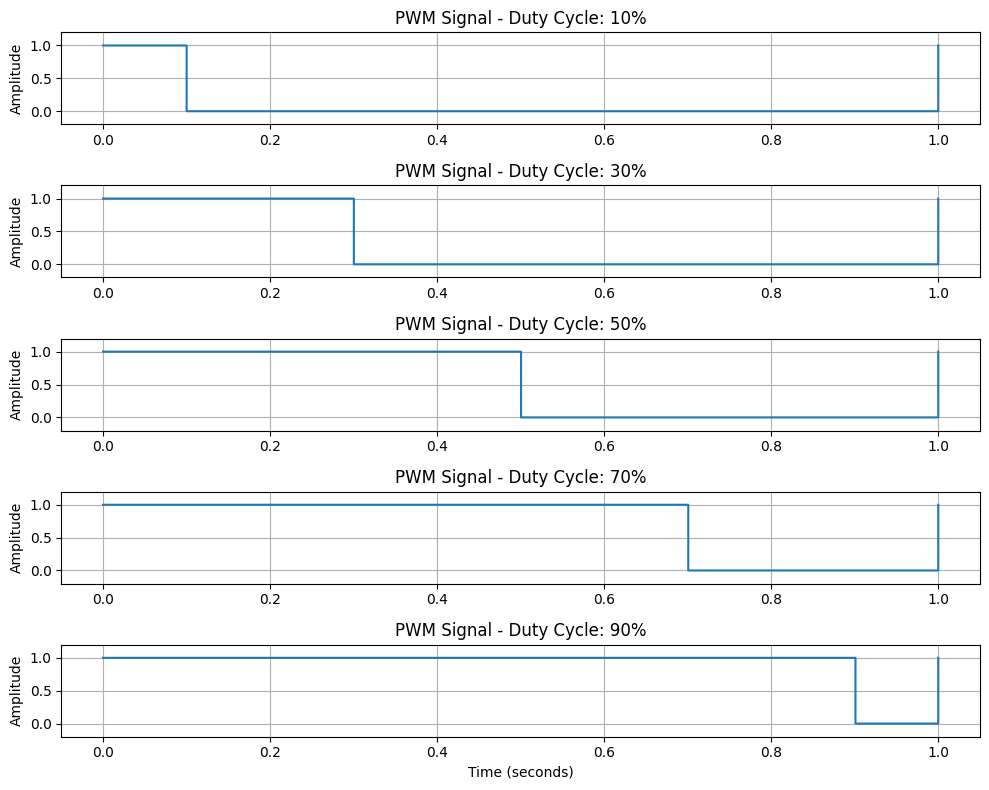

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def generate_pwm_waveform(duty_cycle, frequency=1, t_end=1, samples=1000):
    """
    Generates a PWM signal.
    Parameters:
        duty_cycle (float): The duty cycle of the PWM signal (percentage of time signal is high).
        frequency (float): The frequency of the PWM signal in Hz.
        t_end (float): The end time for the generated signal.
        samples (int): Number of samples in the generated signal.
    Returns:
        t (numpy array): Time vector.
        pwm_signal (numpy array): The PWM signal.
    """
    t = np.linspace(0, t_end, samples)
    period = 1 / frequency
    on_time = period * (duty_cycle / 100)
    pwm_signal = (t % period < on_time).astype(float)
    return t, pwm_signal


frequency = 1  # Hz
duty_cycles = [10, 30, 50, 70, 90]  # Different duty cycles

plt.figure(figsize=(10, 8))

# Generate and plot PWM for different duty cycles
for i, duty_cycle in enumerate(duty_cycles, 1):
    t, pwm_signal = generate_pwm_waveform(duty_cycle, frequency)
    plt.subplot(len(duty_cycles), 1, i)
    plt.plot(t, pwm_signal, drawstyle='steps-post')
    plt.ylim(-0.2, 1.2)
    plt.title(f'PWM Signal - Duty Cycle: {duty_cycle}%')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

In [6]:
#### On-Off Keying (OOK) 

It is a simple form of amplitude-shift keying (ASK), which is a modulation technique used in digital communication. OOK represents digital data as the presence or absence of a carrier wave. In its simplest form, "1" is represented by the presence of the carrier (an "on" state), and "0" is represented by its absence (an "off" state).

To illustrate OOK using Python and matplotlib, I'll generate a simple OOK signal based on a digital binary input string. This example will help visualize how OOK transmits digital data.


SyntaxError: unterminated string literal (detected at line 5) (1745863047.py, line 5)